In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
import numpy as np

In [31]:
class LungNoduleDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = []
        self.labels = []

        for label, class_name in enumerate(["non_nodules", "nodules"]):
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith(".pt"):
                    self.files.append(os.path.join(class_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        tensor = torch.load(self.files[idx])  # Load .pt tensor
        label = self.labels[idx]
        return tensor, label

In [32]:
data_dir = "dataset_split"
batch_size = 32

train_dataset = LungNoduleDataset(os.path.join(data_dir, "train"))
val_dataset = LungNoduleDataset(os.path.join(data_dir, "val"))
test_dataset = LungNoduleDataset(os.path.join(data_dir, "test"))

In [41]:
# Oversampling
n_nodules = 440
n_non_nodules = 23

weight_nodules = 1.0 / n_nodules
weight_non_nodules = 1.0 / n_non_nodules

train_labels = [label for _, label in train_dataset]
weights = [
    weight_nodules if label == 1 else weight_non_nodules for label in train_labels
]

sampler = WeightedRandomSampler(
    weights, num_samples=len(train_dataset), replacement=True
)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}

print("✅ Data Loaders Ready!")

✅ Data Loaders Ready!


In [35]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    "swin_tiny_patch4_window7_224", pretrained=True, num_classes=2
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("✅ Model Ready!")

✅ Model Ready!


In [36]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(dataloaders["train"])
        epoch_acc = correct / total
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}"
        )

    print("✅ Training complete!")

In [37]:
train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.5616, Accuracy: 0.6975
Epoch 2/10, Loss: 0.1904, Accuracy: 0.9537
Epoch 3/10, Loss: 0.0340, Accuracy: 0.9938
Epoch 4/10, Loss: 0.0078, Accuracy: 0.9969
Epoch 5/10, Loss: 0.0029, Accuracy: 1.0000
Epoch 6/10, Loss: 0.0008, Accuracy: 1.0000
Epoch 7/10, Loss: 0.0026, Accuracy: 1.0000
Epoch 8/10, Loss: 0.0036, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0008, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0054, Accuracy: 0.9969
✅ Training complete!


In [38]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

In [39]:
y_true_val, y_pred_val = evaluate_model(model, dataloaders["val"])
y_true_test, y_pred_test = evaluate_model(model, dataloaders["test"])

print("\n📊 Validation Classification Report:\n")
print(
    classification_report(y_true_val, y_pred_val, target_names=["Non-Nodule", "Nodule"])
)

print("\n📊 Test Classification Report:\n")
print(
    classification_report(
        y_true_test, y_pred_test, target_names=["Non-Nodule", "Nodule"]
    )
)


📊 Validation Classification Report:

              precision    recall  f1-score   support

  Non-Nodule       0.00      0.00      0.00         3
      Nodule       0.96      1.00      0.98        66

    accuracy                           0.96        69
   macro avg       0.48      0.50      0.49        69
weighted avg       0.91      0.96      0.94        69


📊 Test Classification Report:

              precision    recall  f1-score   support

  Non-Nodule       0.00      0.00      0.00         4
      Nodule       0.94      1.00      0.97        66

    accuracy                           0.94        70
   macro avg       0.47      0.50      0.49        70
weighted avg       0.89      0.94      0.92        70



c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emada\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


📊 Validation AUC-ROC:


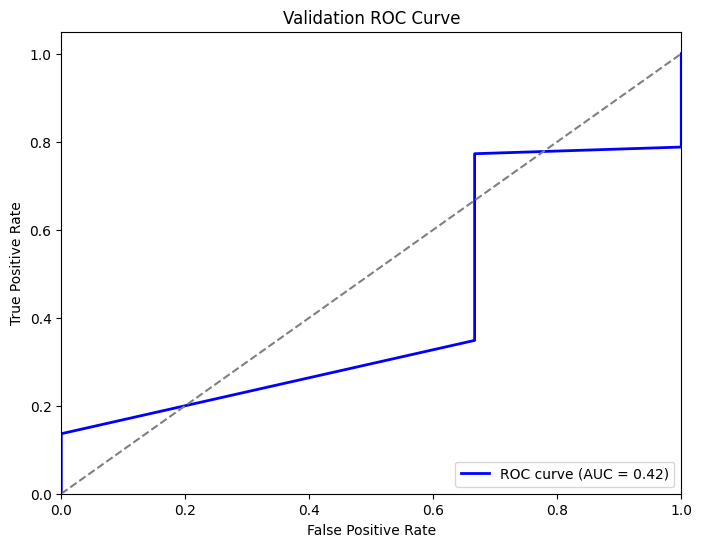

✅ ROC-AUC Score: 0.4217

📊 Test AUC-ROC:


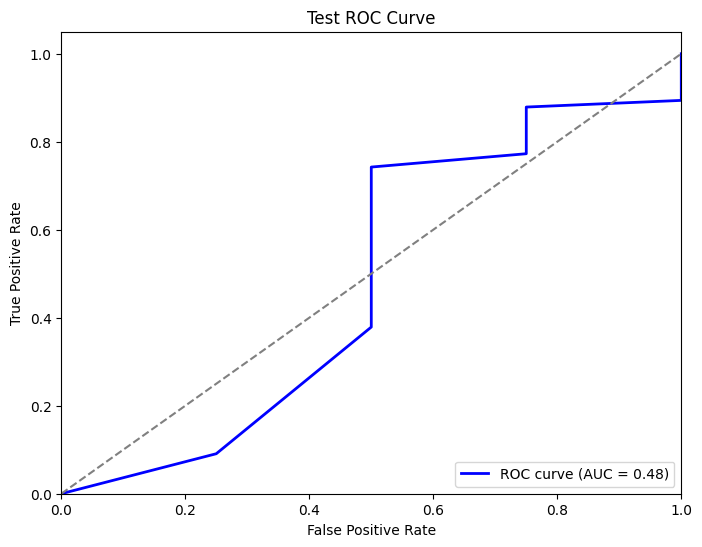

✅ ROC-AUC Score: 0.4811


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score


# -----------------------------
# 📌 Compute AUC-ROC
# -----------------------------
def plot_roc_curve(model, dataloader, title="ROC Curve"):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class "Nodule"

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot(
        [0, 1], [0, 1], color="gray", linestyle="--"
    )  # Diagonal line (random classifier)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    print(f"✅ ROC-AUC Score: {roc_auc:.4f}")


# -----------------------------
# 📌 Run for Validation & Test Set
# -----------------------------
print("\n📊 Validation AUC-ROC:")
plot_roc_curve(model, dataloaders["val"], title="Validation ROC Curve")

print("\n📊 Test AUC-ROC:")
plot_roc_curve(model, dataloaders["test"], title="Test ROC Curve")